In [ ]:
from skimage.feature import register_translation
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import numpy as np
import tensorflow as tf
from sopt.examples.utils import PtychographySimulation
from sopt.examples.tensorflow.far_field_ptychography.tfPtycho import CurveballPhaseRetriever
import sopt.benchmarks.ops.tensorflow.flops_registry_custom
from tensorflow.python.framework import graph_util
from sopt.benchmarks.ops.tensorflow.graph_utils_custom import get_flops_for_sub_graph, get_flops_for_node_list

In [2]:
%load_ext autoreload
%autoreload 2

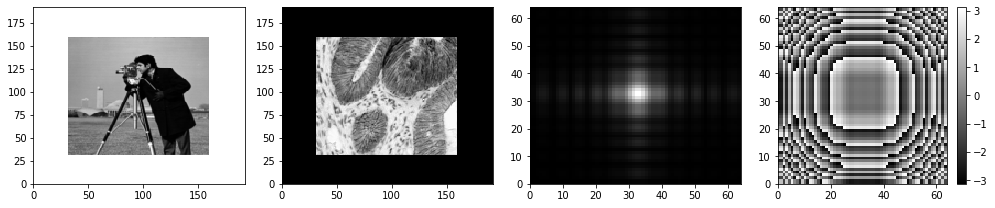

In [3]:
obj_padding_npix = 32
ptsim = PtychographySimulation(obj_npix=128, obj_padding_npix=obj_padding_npix,
                               positions_step_npix=6, probe_n_photons=1e3)

fig, axs = plt.subplots(1, 4, figsize=[14,3])
cax0 = axs[0].pcolormesh(np.abs(ptsim._obj_padded), cmap='gray')
cax1 = axs[1].pcolormesh(np.angle(ptsim._obj_padded), cmap='gray')
cax2 = axs[2].pcolormesh(np.abs(ptsim._probe_true), cmap='gray')
cax3 = axs[3].pcolormesh(np.angle(ptsim._probe_true), cmap='gray')
plt.colorbar(cax3)
plt.tight_layout()
plt.show()

## Curveball - reconstructing the object only

In [19]:
pr_cb = CurveballPhaseRetriever(ptsim=ptsim, 
                                probe_recons=False,
                                validation_ndiffs=0,
                                batch_size=50,
                                loss_type="poisson_surrogate")
pr_cb.setOptimizingParams()
pr_cb.initSession()

In [18]:
for i in range(10):
    pr_cb.run(max_iters=1)
    pr_cb.session.run(pr_cb._obj_clip_op)
pr_cb.data.tail(n=1)

,loss,epoch,obj_error,probe_error,validation_loss,patience
9,12153.238281,1.0,0.566599,NaN,0.0,50.0


In [20]:
pr_cb.run(max_iters=10)
pr_cb.data.tail(n=1)

,loss,epoch,obj_error,probe_error,validation_loss,patience
9,13311.744141,1.0,0.608316,NaN,0.0,50.0


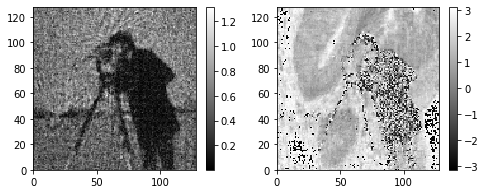

/raid/home/skandel/miniconda3/envs/ad/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


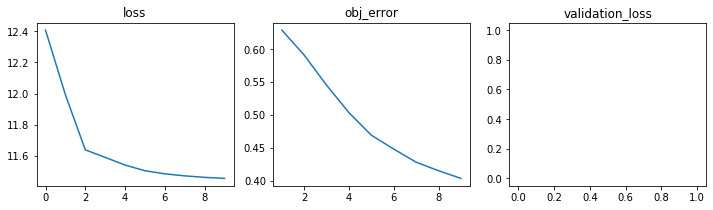

In [16]:
pr_cb.genPlotsRecons()
pr_cb.genPlotMetrics()

In [7]:
with pr_cb.graph.as_default():
    run_meta = tf.RunMetadata()
    opts = tf.profiler.ProfileOptionBuilder.float_operation()    
    flops_cb_and_fwd = tf.profiler.profile(run_meta=run_meta, cmd='scope', options=opts) 
    flops_cb_and_fwd = flops_cb_and_fwd.total_float_ops
    print(f'{flops_cb_and_fwd:4.3g}')

total_flops = pr_cb.data.index[-1] * flops_cb_and_fwd
print(f'{total_flops:4.3g}')

graph_def = pr_cb.graph.as_graph_def()
# To calculate the flops required for one curveball step,
# I am isolating the nodes involved in the damping update.
# Removing this should give me the flops required per step.
# The damping update only happens every 5 steps (by default),
# so I don't want to include it in the default flops value for
# curveball.
nodes_damping = [node for node in graph_def.node if 'damping_update' in node.name]
flops_damping = get_flops_for_node_list(pr_cb.graph, nodes_damping)

nodes_validation = [node for node in graph_def.node if 'validation' in node.name]
flops_validation = get_flops_for_node_list(pr_cb.graph, nodes_validation)

print(f'{flops_damping:4.3g}\t {flops_validation:4.3g}')
total_flops_actual = (flops_cb_and_fwd - flops_damping - flops_validation) * pr_cb.data.index[-1]
print(f'total flops {total_flops_actual:4.3g}')

W1128 18:53:19.528141 140613606635328 deprecation.py:323] From /raid/home/skandel/miniconda3/envs/ad/lib/python3.7/site-packages/tensorflow/python/profiler/internal/flops_registry.py:142: tensor_shape_from_node_def_name (from tensorflow.python.framework.graph_util_impl) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`


1.83e+09
7.15e+11
2.33e+08	 2.36e+07
total flops 6.15e+11


# Curveball - minibatch 100

In [8]:
pr_cb = CurveballPhaseRetriever(ptsim=ptsim, probe_recons=False, batch_size=100, validation_ndiffs=50, 
                                poisson_loss=True)
pr_cb.setOptimizingParams()
pr_cb.initSession()

In [9]:
pr_cb.run()
pr_cb.data.tail(n=1)

10 50887.93 0.918653       50 25534.93 25606.87
20 47971.11 0.9103719       50 24608.94 24737.77
30 44313.45 0.8938026       50 23313.99  23469.2
40 41427.25 0.8715458       60 21832.03 21958.72
50 36667.64 0.8484468       75 20495.82 20644.37
60 34233.62 0.8132096       90 18795.63 19032.81
70 30562.68 0.7732778      105 17202.39 17401.67
80 25868.21 0.7231956      120 15626.52 15760.64
90 23740.84 0.674784      135 14375.21 14479.25
100 22948.14 0.6439266      150 13653.74 13713.97
110 23234.04 0.6118734      165 13003.46 13082.67
120 21057.99 0.5707524      180 12268.97 12329.08
130 21205.96 0.5343188      195 11711.72 11762.16
140  18774.4 0.5067802      210 11363.96 11388.15
150 18974.39 0.4838693      225 11114.43 11138.26
160 19070.27 0.4668656      240 10954.59 10969.52
170  17127.2 0.4516796      255 10820.62 10832.45
180 16714.99 0.4389161      270 10715.28 10727.71
190 19109.23 0.4266366      285 10628.98 10638.71
200 16927.08 0.4164766      300 10562.94 10571.44
210 17733.2

,loss,epoch,obj_error,probe_error,validation_loss,patience
1688,16262.53125,422.0,0.332176,NaN,10396.618164,421.5


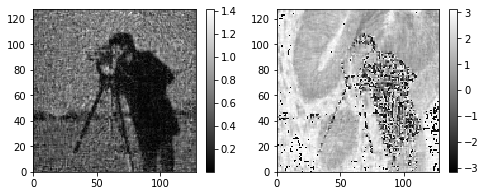

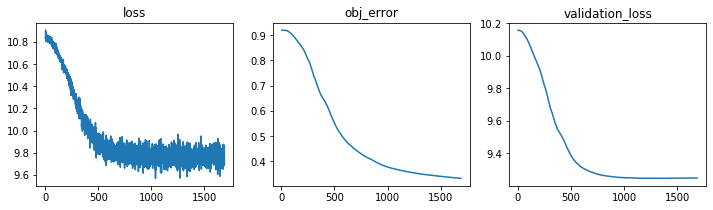

In [10]:
pr_cb.genPlotsRecons()
pr_cb.genPlotMetrics()

In [11]:
with pr_cb.graph.as_default():
    run_meta = tf.RunMetadata()
    opts = tf.profiler.ProfileOptionBuilder.float_operation()    
    flops_cb_and_fwd = tf.profiler.profile(run_meta=run_meta, cmd='scope', options=opts) 
    flops_cb_and_fwd = flops_cb_and_fwd.total_float_ops
    print(f'{flops_cb_and_fwd:4.3g}')

total_flops = pr_cb.data.index[-1] * flops_cb_and_fwd
print(f'{total_flops:4.3g}')

graph_def = pr_cb.graph.as_graph_def()
# To calculate the flops required for one curveball step,
# I am isolating the nodes involved in the damping update.
# Removing this should give me the flops required per step.
# The damping update only happens every 5 steps (by default),
# so I don't want to include it in the default flops value for
# curveball.
nodes_damping = [node for node in graph_def.node if 'damping_update' in node.name]
flops_damping = get_flops_for_node_list(pr_cb.graph, nodes_damping)

nodes_validation = [node for node in graph_def.node if 'validation' in node.name]
flops_validation = get_flops_for_node_list(pr_cb.graph, nodes_validation)

print(f'{flops_damping:4.3g}\t {flops_validation:4.3g}')
total_flops_actual = (flops_cb_and_fwd - flops_damping - flops_validation) * pr_cb.data.index[-1]
print(f'total flops {total_flops_actual:4.3g}')

4.15e+08
7.01e+11
4.92e+07	 2.36e+07
total flops 5.78e+11
